 # Stock Price Estimation using Kalman Filtering

## Modeling Stock Prices

If we denote $X_t$ the price of some stock $X$ at time $t \geq 0$, the multiplicative returns are given by $\frac{X_{t+1}-X_{t}}{X_t}$.

The model we will assume for stock price movement is the log-normal process, meaning, the logarithm of the stock price is assumed to exhibit a random walk.

We can model the price as a geometric Brownian motion process:
$$X(t) = X(0) e^{\nu t + \sigma z(t)}$$
Where $\mu$ and $\sigma \geq 0$ are constants and $z$ is a standard Wiener process.
The price $X(t)$ has a lognormal distribution $ln X(t) - ln X(0) \sim N(\nu t, \sigma^2 t)$

Thus, the multiplicative return between two time steps $t$ and $t+dt$ is given by:
$$\frac{X(t+dt) - X(t)}{X(t)} = \frac{d X(t)}{X(t)} = d ln X(t) = \nu dt + \sigma dz$$  

Meaning, we can consider that:
$$ln(X_{k+1}) - ln(X_k) \approx \frac{X_{k+1}-X_k}{X_k}$$

If the returns $\frac{X_{k+1}-X_k}{X_k}$ follow a normal distribution, since we can approximate it by $ln(X_{k+1}) - ln(k_t)$ it means the increments of the logarithm of the prices are drawing from a normal distribution. Therefore, we can model the returns as a white noise process and the logarithm of the stock price will exhibit a random walk.

In order to gauge the plausibility of this assumption, let us plot a Q-Q plot of Google (GOOGL) returns against a normal distribution.

First, we query the returns using *quantopian's research* library:

In [1]:
from quantopian.research import returns, symbols

period_start = '2018-01-01'
period_end = '2019-01-01'

googl_returns = returns(
    assets=symbols('GOOG_L'),
    start=period_start,
    end=period_end,
)

Then, plot the Q-Q plot using the *statsmodel* library:

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


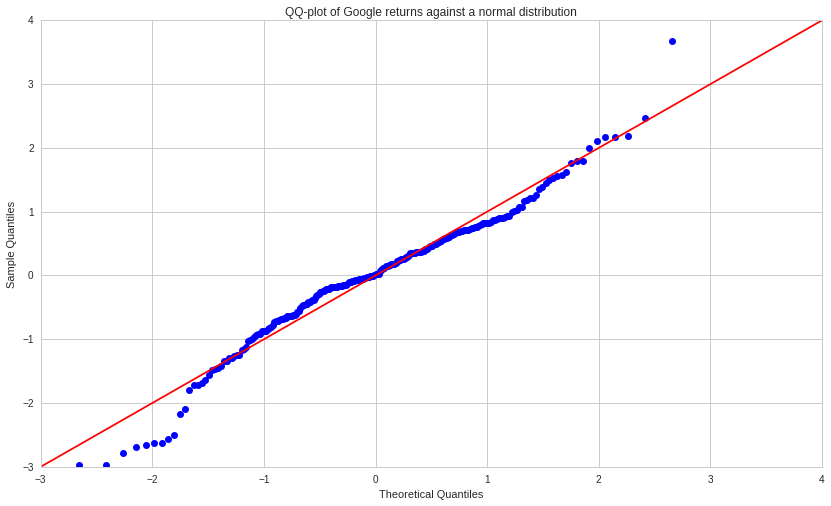

In [2]:
import statsmodels.api as sm
from matplotlib import pyplot as plt

sm.qqplot(googl_returns.values, line='45', fit=True)
plt.title('QQ-plot of Google returns against a normal distribution')
plt.legend();

The closer the points are to the straight line, the more the actual distribution behaves like a normal distribution.
Let us now plot the distribution of Google's returns against a normal distribution with same mean and variance.

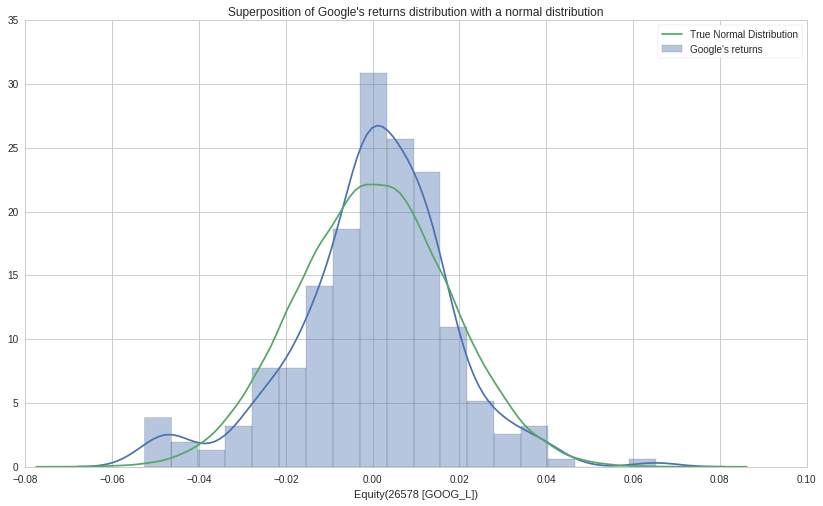

In [3]:
import seaborn as sns
import numpy as np
mean = googl_returns.mean()
std = googl_returns.std()

norm = np.random.normal(mean, std, 50000)

sns.distplot(googl_returns, label = 'Google\'s returns')
sns.distplot(norm, hist=None, label = 'True Normal Distribution')
plt.title('Superposition of Google\'s returns distribution with a normal distribution')
plt.legend();

From these plots, we can see our assumption that stock prices follow a log-normal distribution has certain limitations.

## Filtering the stock prices

We consider the stock price at each time step as the equlibrium price at which supply meets demand. During this time interval, this price is subject to certain variations due to market microstructure.

Our goal is thus to use **Kalman filtering to uncover the underlying truth value of the stock returns** given the observed data. Let us denote $\{x_k\}_{k\in [0,n]}$ the set of state variables we wish to discover and $\{y_k\}_{k\in [0,n]}$ the set of measurements. Both process and measurement equations are linear (since we assume the stock returns to exhibit a random walk, the process has a linear form) and given by:

$$x_{n+1} = x_n + \epsilon_{n+1} \text{ with } \epsilon_{n+1} \underbrace{\sim}_{\text{i.i.d.}} \mathcal{N} (0, \sigma_{\epsilon}^2)$$
$$y_n = x_n + e_n \text{ with } e_{n+1} \underbrace{\sim}_{\text{i.i.d.}} \mathcal{N} (0, \sigma_{e}^2)$$

We assume our measurements have no systematic bias, that is $\mathbb{E} [\beta] = 0$

A detailed **Bayesian derivation of the Kalman Filter** equations can be found [here](https://adamsc.mycpanel.princeton.edu/documents/KalmanFilterBayesDerivation.pdf).

In order to use a Kalman filter, we need to give it transition and observation matrices, transition and observation covariance matrices, and the initial state.

Given our problem, we are filtering a scalar and will therefore work with scalar parameters. 
<br>
We denote $\{\hat{x_k}\}_{k\in [0,n]}$ our estimate for $\{x_k\}$ with variance $p_k$. The transition variance is given by $\sigma_{\epsilon}^2$ and the observation variance is given by $\sigma_{e}^2$.

Given the Kalman Filter equations, we have:
$$\hat{x}_{n|n-1} = \hat{x}_{n-1}$$
$$p_{n|n-1} = p_{n-1} + \sigma_{\epsilon}^2$$
$$\hat{x}_n = \hat{x}_{n|n-1} + K_n (y_n - \hat{x}_{n|n-1})$$
$$K_n = \frac{p_{n|n-1}}{\sigma_{e}^2 + p_{n|n-1}}$$
$$p_n = p_{n|n-1}(1-K_n)$$

- Moreover, given that we begin filtering the stock returns at time $t > 0$, we can estimate $p_0$ as the *historical volatility* that is the variance of the stock returns up to $t$.

- Furthermore, we can estimate the transition variance $\sigma_{\epsilon}$ as the variance of the increments between the log returns up to $t$. 

- Finally, we can estimate the observation variance $\sigma_{e}$ as the volatility of the stock return in the time period, characterized by the highs and lows of the stock. [L. Rogers and S. Satchell](https://projecteuclid.org/download/pdf_1/euclid.aoap/1177005835) provide an estimator for $\sigma_{e}$ given the high, low and close price of a stock during a certain time step. 
<br>Indeed, denoting the high $S_t = sup(X_k, k \leq t)$ and the low $I_t = inf(X_k, k \leq t)$ as well as the close price $X_t$, we have:
$$\hat{\sigma_e}^2 = S_1 (S_1 - X_1) + I_1 (I_1 - X_1)$$
<br>
The paper proves that: $\mathbb{E}[S_t (S_t - X_t) + I_t (I_t - X_t)] = \sigma_e^2 t$
<br>
$\sigma_e$ represents the variance in the measurements of $x_k$ and we will estimate it by averaging the estimated $\hat{\sigma_e}$ up to the time we begin the filtering.

- Our initial estimate $\hat{x}_0$ will be the close price at the time we begin filtering.

Given that we want to start filtering on Jan 1st 2018, let us estimating all those parameters using data prior to that date. We first create a pipeline containing US equities during the timeframe of interest and then filter the equity we are interested in (GOOGL).

In [4]:
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import EquityPricing
from quantopian.pipeline.domain import US_EQUITIES
from quantopian.research import run_pipeline

yesterday_open = EquityPricing.open.latest
yesterday_close = EquityPricing.close.latest
yesterday_high = EquityPricing.high.latest
yesterday_low = EquityPricing.low.latest

pipe = Pipeline(
    columns={
        'open': yesterday_open,
        'close': yesterday_close,
        'high': yesterday_high,
        'low': yesterday_low
    },
    domain=US_EQUITIES,
)

df = run_pipeline(pipe, '2017-10-01', '2018-01-01')
print(df.head())

                                                 close    high     low    open
2017-10-02 00:00:00+00:00 Equity(2 [ARNC])       24.88   26.04   24.55   26.04
                          Equity(21 [AAME])       3.25    3.25    3.15    3.25
                          Equity(24 [AAPL])     154.03  154.13  152.00  153.21
                          Equity(25 [ARNC_PR])     NaN     NaN     NaN     NaN
                          Equity(31 [ABAX])      44.64   44.78   44.00   44.41


In [5]:
import pandas as pd
idx = pd.IndexSlice
df_googl = df.loc[idx[:, symbols('GOOG_L')], :].reset_index().drop('level_1', axis=1).rename(columns={'level_0':'date'}).set_index('date')
df_googl.head()

,close,high,low,open
date,,,,
2017-10-02 00:00:00+00:00,973.77,975.810,966.000,966.00
2017-10-03 00:00:00+00:00,967.47,977.740,961.950,975.65
2017-10-04 00:00:00+00:00,972.08,972.440,962.705,967.56
2017-10-05 00:00:00+00:00,966.39,974.400,965.610,971.76
2017-10-06 00:00:00+00:00,985.66,986.509,970.270,972.79


We can then estimate $p_0$, $\sigma_\epsilon$ and $\sigma_e$:

In [6]:
p_0 = df_googl.close.var()
print('p_0 = {}'.format(p_0))

p_0 = 928.655637956


In [7]:
eps = df_googl.close.diff()/df_googl.close
eps = eps.dropna()
sigma_eps_squared = eps.var()
print('sigma_eps^2 = {}'.format(sigma_eps_squared))

sigma_eps^2 = 9.68760813222e-05


In [8]:
H = np.log(df_googl.high / df_googl['open'])
L = np.log(df_googl.low / df_googl['open'])
S = np.log(df_googl.close / df_googl['open'])
e = H*(H-S)+L*(L-S)
sigma_e_squared = e.mean()
print('sigma_e^2 = {}'.format(e.mean()))

sigma_e^2 = 9.42824910717e-05


We can now import the log prices of GOOGL and set up the filter using the library *KalmanFilter*:

In [9]:
from quantopian.research import log_prices, symbols

period_start = '2018-01-01'
period_end = '2018-05-01'

googl_log_prices = log_prices(
    assets=symbols('GOOG_L'),
    start=period_start,
    end=period_end,
)

In [10]:
x_0 = googl_log_prices[0]

In [20]:
from pykalman import KalmanFilter
kf = KalmanFilter(n_dim_obs=1, n_dim_state=1,
                  initial_state_mean=x_0,
                  initial_state_covariance=p_0,
                  transition_matrices=1,
                  observation_matrices=1,
                  observation_covariance=sigma_e_squared,
                  transition_covariance=sigma_eps_squared,
                  transition_offsets=0)

In [21]:
state_means, state_covs = kf.filter(googl_log_prices)

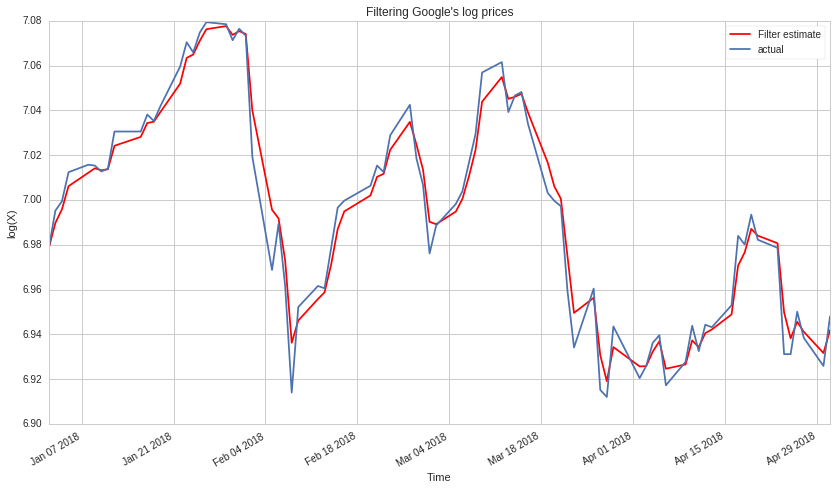

In [22]:
plt.plot(googl_log_prices.index, state_means[:,0], label='Filter estimate', c='r')
googl_log_prices.plot(label='actual')
plt.xlabel('Time')
plt.ylabel('log(X)')
plt.title('Filtering Google\'s log prices')
plt.legend();

Moreover, the confidence in the estimate increases with time:

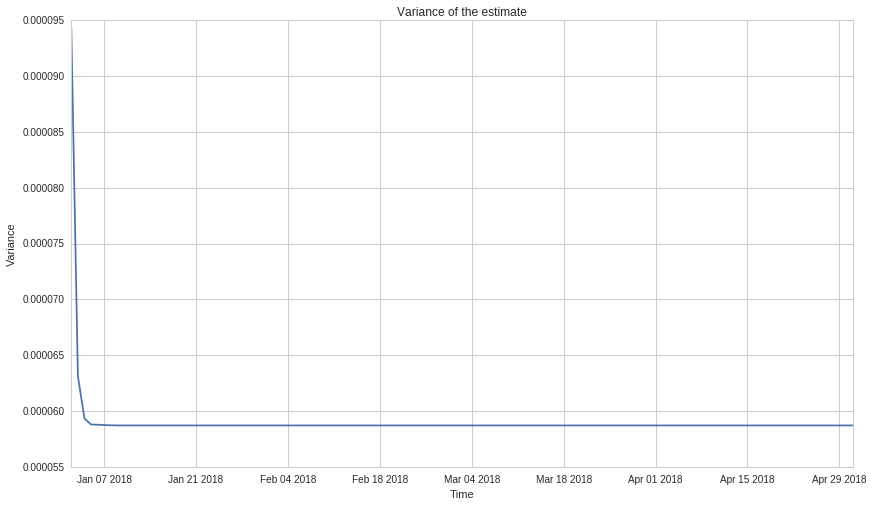

In [23]:
plt.plot(googl_log_prices.index, state_covs[:,0,0])
plt.title('Variance of the estimate')
plt.ylabel('Variance')
plt.xlabel('Time');

We can see that Kalman Filtering allows us to construct better smoothers than moving averages, which tend to lag when there are sharp changes in price movement.
To achieve varying degrees of smoothness using the Kalman filter, we can sample the random walk sequence at multiple frequencies (resulting in a new random walk sequence with different parameters).

## References
- Ganapathy Vidyamurthy - Pairs Trading: Quantitative Methods and Analysis (2004, Wiley)
- Rogers, L. and S. Satchell. “Estimating Variance from High Low and Closing Prices.” Annals of Applied Probability 1, no. 4 (1991): 504–512.
- Rogers, L., S. Satchell and Y. Yoon. “Estimating the Volatility of Stock Prices: A Comparison of Methods That Use High and Low Prices.” Applied Financial Economics 4 (1994): 241–247.